# **RAVDESSデータセットの学習コード**

**ライブラリ**

In [ ]:
!pip install -U efficientnet -qq

     |████████████████████████████████| 50 kB 5.4 MB/s 


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import glob
import os
import cv2

import IPython.display as ipd 

import librosa 
import librosa.display

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

import efficientnet.tfkeras as efn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#ravdessデータセットのパス
RAVD = "/content/drive/MyDrive/archive/audio_speech_actors_01-24/"

In [ ]:
#データセット作成
dirl_list = os.listdir(RAVD)
dirl_list.sort()

emotion = []
gender = []
path = []
for i in dirl_list:
    fname = os.listdir(RAVD + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVD + i + '/' + f)

        
RAVD_df = pd.DataFrame(emotion)
RAVD_df = RAVD_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAVD_df = pd.concat([pd.DataFrame(gender),RAVD_df],axis=1)
RAVD_df.columns = ['gender','emotion']
RAVD_df['labels'] =RAVD_df.gender + '_' + RAVD_df.emotion
RAVD_df['source'] = 'RAVDESS'  
RAVD_df = pd.concat([RAVD_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAVD_df = RAVD_df.drop(['gender', 'emotion'], axis=1)
RAVD_df.labels.value_counts()

**女性用データセット**

In [ ]:
female_df = RAVD_df[(RAVD_df["labels"] == "female_surprise") | (RAVD_df["labels"] == "female_sad") | (RAVD_df["labels"] == "female_happy") | (RAVD_df["labels"] == "female_angry")]
female_df.head()

,labels,source,path
60,female_happy,RAVDESS,/content/drive/MyDrive/archive/audio_speech_ac...
68,female_happy,RAVDESS,/content/drive/MyDrive/archive/audio_speech_ac...
74,female_sad,RAVDESS,/content/drive/MyDrive/archive/audio_speech_ac...
75,female_angry,RAVDESS,/content/drive/MyDrive/archive/audio_speech_ac...
76,female_happy,RAVDESS,/content/drive/MyDrive/archive/audio_speech_ac...


**男性用データセット**

In [ ]:
male_df = RAVD_df[(RAVD_df["labels"] == "male_surprise") | (RAVD_df["labels"] == "male_sad") | (RAVD_df["labels"] == "male_happy") | (RAVD_df["labels"] == "male_angry")]
male_df.head()

**スペクトログラム生成**

In [ ]:
#女性用データセット
import glob
import pandas as pd
df = pd.DataFrame(columns=["path","spc_path", "label"])

for row in female_df.itertuples():
  # print(row)
  filePath = row.path
  label =row.labels
  spc_name = "/content/drive/MyDrive/rav_spec/" + filePath.split("/")[-1][:-4]
  spc_path = "/content/drive/MyDrive/rav_spec/" + filePath.split("/")[-1][:-4] + ".npy"
  signal, sr = librosa.load(filePath)
  # if len(signal) >= 99225:
  signal = signal[11025:88200] #22050 *4.5

  x1 = librosa.feature.melspectrogram(y=signal, sr=22050)   
  x2 = librosa.power_to_db(x1, ref=np.max)
  np.save(spc_name, x2)
  df = df.append({'path': path,'spc_path': spc_path, 'label': label}, ignore_index=True)



In [ ]:
#男性用データセット
import glob
import pandas as pd
df = pd.DataFrame(columns=["path","spc_path", "label"])

for row in male_df.itertuples():
  # print(row)
  filePath = row.path
  label =row.labels
  spc_name = "/content/drive/MyDrive/rav_spec_male/" + filePath.split("/")[-1][:-4]
  spc_path = "/content/drive/MyDrive/rav_spec_male/" + filePath.split("/")[-1][:-4] + ".npy"
  signal, sr = librosa.load(filePath)
  # if len(signal) >= 99225:
  signal = signal[11025:] #22050 *4.5

  x1 = librosa.feature.melspectrogram(y=signal, sr=22050)   
  x2 = librosa.power_to_db(x1, ref=np.max)
  np.save(spc_name, x2)
  df = df.append({'path': path,'spc_path': spc_path, 'label': label}, ignore_index=True)



In [ ]:
df.head()

In [ ]:
signal, sr = librosa.load("/content/drive/MyDrive/archive/Actor_01/03-01-02-01-01-02-01.wav")
print(signal.shape)
print(sr)
print(len(signal) / sr)

(79460,)
22050
3.603628117913832


(128, 134)


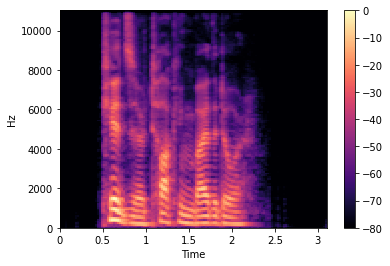

In [ ]:
x1 = librosa.feature.melspectrogram(y=new_signal, sr=22050)   
x2 = librosa.power_to_db(x1, ref=np.max)   

print(x2.shape)

librosa.display.specshow(x2, sr=22050, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

**ラベルエンコーダー**

In [ ]:
labels = np.unique(df.label.values)
label_encoder = {label:i for i, label in enumerate(labels)}
# label_decoder = {0:"angry", 1:"happy", 2:"normal"}

In [ ]:
label_encoder
#{'female_angry': 0, 'female_happy': 1, 'female_sad': 2, 'female_surprise': 3}

{'male_angry': 0, 'male_happy': 1, 'male_sad': 2, 'male_surprise': 3}

**DataGenerator**

(8, 128, 172, 3)
[1. 2. 2. 2. 2. 1. 1. 2.]


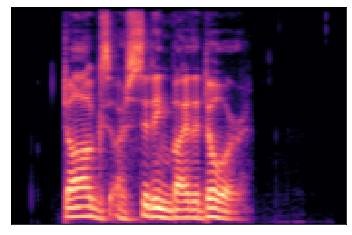

In [ ]:
IMG_SIZE = (128,172)
#(128, 194)
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, df, batch_size=32, shuffle=True, is_train=True):
        self.df = df
        self.n = len(df)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.is_train = is_train
        self.on_epoch_end()
        
    def on_epoch_end(self):
        self.indices = np.arange(self.n)
        if self.shuffle == True:
            np.random.shuffle(self.indices)   
    
    def __len__(self):
        
        return math.ceil( self.n / self.batch_size )
    
    def __getitem__(self, batch_index):
        
        start = batch_index * self.batch_size
        end = (batch_index + 1) * self.batch_size
        
        indices = self.indices[start:end]
        
        return self.__data_generation(indices)
    
    def __data_generation(self, batch_indices):
        batch_size = len(batch_indices)
        
        X = np.zeros(shape=(batch_size, IMG_SIZE[0], IMG_SIZE[1], 3))
        y = np.zeros(batch_size)
        
        for i, idx in enumerate(batch_indices):
            path = self.df.spc_path.values[idx]
            LABEL = self.df.label.values[idx]
            

            try:
                data_array = np.load(path)
                resized = cv2.resize(data_array, (IMG_SIZE[1], IMG_SIZE[0]))
                
                for j in range(3):
                    X[i,:,:,j] = resized 
                
            except:
                print('skipped')

            if self.is_train:
                y[i] = label_encoder[LABEL]

        if self.is_train:    
            return X, y
        return X

    
GENERATOR_TEST = True

if GENERATOR_TEST:
    temp_gen = DataGenerator(df, batch_size=8, shuffle=False)
    X,y = temp_gen.__getitem__(0)

    print(X.shape)
    print(y)
    
    librosa.display.specshow(X[0, :, :, 0])

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=1, stratify=df.label)

print(train_df.shape)
print(valid_df.shape)

(307, 3)
(77, 3)


In [ ]:
train_loader = DataGenerator(train_df, batch_size=32, shuffle=True)
valid_loader = DataGenerator(valid_df, batch_size=32, shuffle=False)

In [ ]:
TR_STEPS = len(train_loader)
VA_STEPS = len(valid_loader)

print(TR_STEPS)
print(VA_STEPS)

10
3


**モデル**

In [ ]:
ENB1_model = efn.EfficientNetB1(input_shape=(128,172,3), include_top=False, weights='imagenet')
ENB1_model.trainable = True

In [ ]:
cnn = Sequential([
    ENB1_model,
    
    Flatten(),
    
    Dense(64, activation='relu'),
    Dropout(0.45),
    
    Dense(32, activation='relu'),
    Dropout(0.45),
    
    Dense(4, activation='softmax')
])

cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b1 (Functional  (None, 4, 6, 1280)       6575232   
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 30720)             0         
                                                                 
 dense_9 (Dense)             (None, 64)                1966144   
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                      

In [ ]:
opt = tf.keras.optimizers.Adam(0.0001)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

**学習**

In [ ]:
h1 = cnn.fit(train_loader, steps_per_epoch = TR_STEPS, epochs = 40, validation_data = valid_loader, 
             validation_steps = VA_STEPS, verbose = 1)

cnn.save(f'/content/drive/MyDrive/model/audio_emotion_rav_female.h5')

In [ ]:
h1 = cnn.fit(train_loader, steps_per_epoch = TR_STEPS, epochs = 50, validation_data = valid_loader, 
             validation_steps = VA_STEPS, verbose = 1)
#0.72

cnn.save(f'/content/drive/MyDrive/model/audio_emotion_rav_male_ver3.h5')

Epoch 1/50
10/10 [==============================] - 16s 417ms/step - loss: 1.8606 - accuracy: 0.2899 - val_loss: 1357.7169 - val_accuracy: 0.2727
Epoch 2/50
10/10 [==============================] - 2s 232ms/step - loss: 1.5132 - accuracy: 0.2964 - val_loss: 558.8610 - val_accuracy: 0.2468
Epoch 3/50
10/10 [==============================] - 2s 228ms/step - loss: 1.3688 - accuracy: 0.3779 - val_loss: 302.6837 - val_accuracy: 0.2468
Epoch 4/50
10/10 [==============================] - 2s 230ms/step - loss: 1.3089 - accuracy: 0.3844 - val_loss: 131.3938 - val_accuracy: 0.2468
Epoch 5/50
10/10 [==============================] - 2s 231ms/step - loss: 1.2209 - accuracy: 0.4625 - val_loss: 155.6713 - val_accuracy: 0.2078
Epoch 6/50
10/10 [==============================] - 2s 238ms/step - loss: 1.1029 - accuracy: 0.5114 - val_loss: 161.5809 - val_accuracy: 0.2727
Epoch 7/50
10/10 [==============================] - 2s 234ms/step - loss: 1.1266 - accuracy: 0.4951 - val_loss: 89.3951 - val_accuracy

**学習結果の可視化**

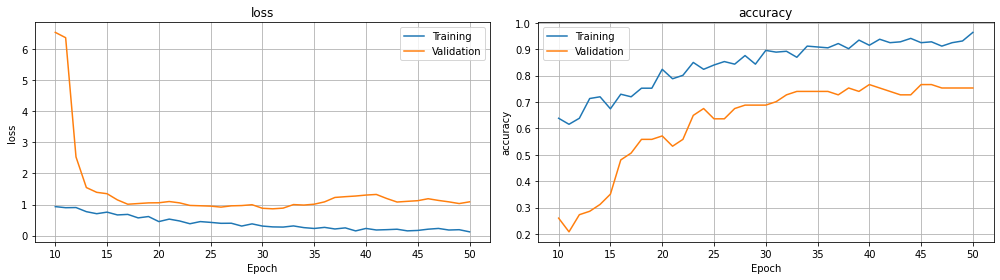

In [ ]:
def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

history = merge_history([h1])
vis_training(history, start=10)

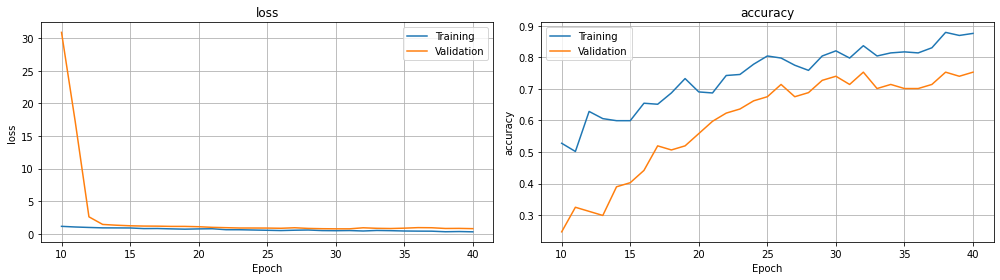

In [ ]:
def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

history = merge_history([h1])
vis_training(history, start=10)

In [ ]:
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

history = merge_history([h1])
vis_training(history, start=10)

**データセットで検証**

In [ ]:
path = "/content/drive/MyDrive/voice_corpus/tsuchiya_happy/tsuchiya_happy_004.wav"
path = "/content/drive/MyDrive/archive/Actor_01/03-01-03-01-01-02-01.wav"
ipd.Audio(path)

In [ ]:
df

In [ ]:
signal, sr = librosa.load(path)
if len(signal) <= 99225:
  signal = signal[:80225] #22050 *4.5

x1 = librosa.feature.melspectrogram(y=signal, sr=22050)   
x2 = librosa.power_to_db(x1, ref=np.max)


IMG_SIZE = (128,172)

X = np.zeros(shape=(1, IMG_SIZE[0], IMG_SIZE[1], 3))

resized = cv2.resize(x2, (IMG_SIZE[1], IMG_SIZE[0]))

for j in range(3):
    X[0,:,:,j] = resized
     
        
              

In [ ]:
y_test = cnn.predict(X)
y_test
# print(label_decoder[np.argmax(y_test)])

array([[0.03932559, 0.07858064, 0.11477831, 0.7673154 ]], dtype=float32)